In [1]:
# Install pyspark
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.4/281.4 MB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 KB 21.3 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.3.2-py2.py3-none-any.whl size=281824025 sha256=55cc4e674d9c3af164a80d60b47a75b4fc0813eb492e7b9ab4fac7f08dce4422
  Stored in directory: /root/.cache/pip/wheels/b1/59/a0/a1a0624b5e865fd389919c1a10f53aec9b12195d6747710baf
Successfully built pyspark


In [2]:
#install needed libraries
import math
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pyspark.sql.functions as F
from pyspark.sql import SQLContext
from pyspark import SparkContext
from pyspark.sql.types import *
from pyspark.sql import functions as f
from pyspark.sql.types import IntegerType
from IPython import display



In [3]:
#create SparkContext
sc =SparkContext()
sqlContext = SQLContext(sc)

/usr/local/lib/python3.8/dist-packages/pyspark/sql/context.py:112: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


**Data_phase**

In [4]:
customSchema = StructType([
    StructField("clean_text", StringType()), 
    StructField("category", IntegerType())])

In [5]:
#data.csv file contains 10000 tweets with seach query 
reddit = '/content/Reddit_Data.csv'
twitter = '/content/Twitter_Data.csv'

In [6]:
df1 = sqlContext.read.format("csv").option("header", "true").schema(customSchema).load(twitter)
df1.count()

192131

In [7]:
df2 = sqlContext.read.format("csv").option("header", "true").schema(customSchema).load(reddit)
df2.count()

38305

**Merge twitter dataset and radit dataset in one dataframe**

In [8]:
df = df1.union(df2)#, emp_acc_LoadCsvDF("acc_id").equalTo(emp_info_LoadCsvDF("info_id")), "inner").selectExpr("acc_id", "name", "salary", "dept_id", "phone", "address", "email")
df.count() 

230436

In [9]:
# Find Count of Null, None, NaN of All DataFrame Columns
from pyspark.sql.functions import col,isnan, when, count
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]
   ).show()

+----------+--------+
|clean_text|category|
+----------+--------+
|       104|   34755|
+----------+--------+



In [10]:
df.describe().show()

+-------+--------------------+------------------+
|summary|          clean_text|          category|
+-------+--------------------+------------------+
|  count|              230333|            195681|
|   mean|                 NaN|0.2213602751416847|
| stddev|                 NaN|0.7816161106904199|
|    min|                    |                -1|
|    max|�modi mistake� ch...|                 1|
+-------+--------------------+------------------+



In [11]:
def find_outliers(df):

    # Identifying the numerical columns in a spark dataframe
    numeric_columns = [column[0] for column in df.dtypes if column[1]=='int']

    # Using the `for` loop to create new columns by identifying the outliers for each feature
    for column in numeric_columns:

        less_Q1 = 'less_Q1_{}'.format(column)
        more_Q3 = 'more_Q3_{}'.format(column)
        Q1 = 'Q1_{}'.format(column)
        Q3 = 'Q3_{}'.format(column)

        # Q1 : First Quartile ., Q3 : Third Quartile
        Q1 = df.approxQuantile(column,[0.25],relativeError=0)
        Q3 = df.approxQuantile(column,[0.75],relativeError=0)
        
        # IQR : Inter Quantile Range
        # We need to define the index [0], as Q1 & Q3 are a set of lists., to perform a mathematical operation
        # Q1 & Q3 are defined seperately so as to have a clear indication on First Quantile & 3rd Quantile
        IQR = Q3[0] - Q1[0]
        
        #selecting the data, with -1.5*IQR to + 1.5*IQR., where param = 1.5 default value
        less_Q1 =  Q1[0] - 1.5*IQR
        more_Q3 =  Q3[0] + 1.5*IQR
        
        isOutlierCol = 'is_outlier_{}'.format(column)
        
        df = df.withColumn(isOutlierCol,f.when((df[column] > more_Q3) | (df[column] < less_Q1), 1).otherwise(0))
    

    # Selecting the specific columns which we have added above, to check if there are any outliers
    selected_columns = [column for column in df.columns if column.startswith("is_outlier")]

    # Adding all the outlier columns into a new colum "total_outliers", to see the total number of outliers
    df = df.withColumn('total_outliers',sum(df[column] for column in selected_columns))

    # Dropping the extra columns created above, just to create nice dataframe., without extra columns
    df = df.drop(*[column for column in df.columns if column.startswith("is_outlier")])

    return df

In [12]:
#detect outliers in our dataset
new_df = find_outliers(df)
new_df.show()

+--------------------+--------+--------------+
|          clean_text|category|total_outliers|
+--------------------+--------+--------------+
|when modi promise...|      -1|             0|
|talk all the nons...|       0|             0|
|what did just say...|       1|             0|
|asking his suppor...|       1|             0|
|answer who among ...|       1|             0|
|kiya tho refresh ...|       0|             0|
|surat women perfo...|    null|             0|
|                  ,0|    null|             0|
|this comes from c...|       0|             0|
|with upcoming ele...|       1|             0|
|gandhi was gay do...|       1|             0|
|things like demon...|       1|             0|
|hope tuthukudi pe...|       1|             0|
|calm waters where...|       1|             0|
|one vote can make...|       0|             0|
|one vote can make...|       0|             0|
|vote such party a...|      -1|             0|
|vote modi who has...|       0|             0|
|through our 

In [13]:
def pieplot(df, col, lim=10, yname=None):
    
    '''
    This function makes a pie chart for the Spark dataframe df 
    for categorical column col only selecting top categories 
    as specified by lim. 
    '''
    
    # Grouping by the categories, counting on each categories 
    # and ordering them by the count
    classes = df.groupBy(col).count().orderBy('count', ascending=False)
    
    # Take first 'lim' number of rows and convert to pandas  
    pd_df = classes.limit(lim).toPandas()
    
    # Making plot 
    pd_df.plot(kind='pie', x=col, y='count', \
           labels=pd_df[col], legend=False)
    plt.ylabel(None)
    plt.show()

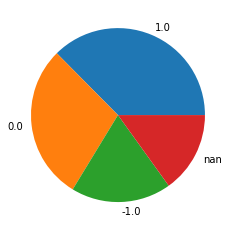

In [14]:
#show data with nan values
pieplot(df, 'category')

In [15]:
# cleaning the data with drop null values
data = df.na.drop(how='any')
data.show(5)

+--------------------+--------+
|          clean_text|category|
+--------------------+--------+
|when modi promise...|      -1|
|talk all the nons...|       0|
|what did just say...|       1|
|asking his suppor...|       1|
|answer who among ...|       1|
+--------------------+--------+
only showing top 5 rows



In [16]:
data.select('clean_text').show(10)


+--------------------+
|          clean_text|
+--------------------+
|when modi promise...|
|talk all the nons...|
|what did just say...|
|asking his suppor...|
|answer who among ...|
|kiya tho refresh ...|
|this comes from c...|
|with upcoming ele...|
|gandhi was gay do...|
|things like demon...|
+--------------------+
only showing top 10 rows



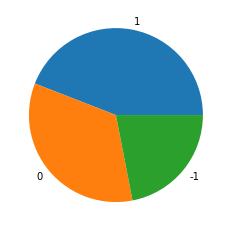

In [17]:
#show data without nan values
pieplot(data, 'category')

In [18]:
#count  the number of redundant category values
from pyspark.sql.functions import col

data.groupBy("category").count().orderBy(col("count").desc()).show()

+--------+-----+
|category|count|
+--------+-----+
|       1|86224|
|       0|66446|
|      -1|42908|
+--------+-----+



Model Pipeline

Spark Machine Learning Pipelines API is similar to Scikit-Learn. Our pipeline includes three steps:

regexTokenizer
stopwordsRemover
countVectors


In [19]:
#piplines steps
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, CountVectorizer
from pyspark.ml.classification import LogisticRegression

# regular expression tokenizer
regexTokenizer = RegexTokenizer(inputCol="clean_text", outputCol="words", pattern="\\W")

# stop words
add_stopwords = ["http","https","amp","rt","t","c","the"] 

stopwordsRemover = StopWordsRemover(inputCol="words", outputCol="filtered").setStopWords(add_stopwords)

# bag of words count
countVectors = CountVectorizer(inputCol="filtered", outputCol="features", vocabSize=30000, minDF=5)

**preprocessing data using piplines steps**






In [20]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
label_stringIdx = StringIndexer(inputCol = "category", outputCol = "label")

pipeline = Pipeline(stages=[regexTokenizer, stopwordsRemover, countVectors, label_stringIdx])

# Fit the pipeline to training documents.
pipelineFit = pipeline.fit(data)
dataset = pipelineFit.transform(data)
dataset.show(5)

+--------------------+--------+--------------------+--------------------+--------------------+-----+
|          clean_text|category|               words|            filtered|            features|label|
+--------------------+--------+--------------------+--------------------+--------------------+-----+
|when modi promise...|      -1|[when, modi, prom...|[when, modi, prom...|(24654,[0,1,7,30,...|  2.0|
|talk all the nons...|       0|[talk, all, the, ...|[talk, all, nonse...|(24654,[0,1,2,8,1...|  1.0|
|what did just say...|       1|[what, did, just,...|[what, did, just,...|(24654,[0,2,3,20,...|  0.0|
|asking his suppor...|       1|[asking, his, sup...|[asking, his, sup...|(24654,[0,6,7,8,1...|  0.0|
|answer who among ...|       1|[answer, who, amo...|[answer, who, amo...|(24654,[0,22,69,1...|  0.0|
+--------------------+--------+--------------------+--------------------+--------------------+-----+
only showing top 5 rows



**Data partitioning**

In [21]:
# set seed for reproducibility
(D_train, D_test) = dataset.randomSplit([0.7, 0.3], seed = 100)

#count the samples of every test
print("The Training Dataset Count is: " + str(D_train.count()))
print("The Test Dataset Count is: " + str(D_test.count()))

The Training Dataset Count is: 136811
The Test Dataset Count is: 58767


In [22]:
D_train.describe().show()

+-------+-----------------------+------------------+------------------+
|summary|             clean_text|          category|             label|
+-------+-----------------------+------------------+------------------+
|  count|                 136811|            136811|            136811|
|   mean|                    NaN|0.2217877217475203|0.7782122782524797|
| stddev|                    NaN|0.7823116472855645|0.7823116472855647|
|    min|                       |                -1|               0.0|
|    max|（ ͡° ͜ ͡° ━☆・。 ⊂ ...|                 1|               2.0|
+-------+-----------------------+------------------+------------------+



In [23]:
D_test.describe().show()

+-------+--------------------+------------------+------------------+
|summary|          clean_text|          category|             label|
+-------+--------------------+------------------+------------------+
|  count|               58767|             58767|             58767|
|   mean|              6949.8|0.2207531437711641|0.7792468562288359|
| stddev|  12787.608013229057|0.7806099070639413|0.7806099070639412|
|    min|                    |                -1|               0.0|
|    max|�modi mistake� ch...|                 1|               2.0|
+-------+--------------------+------------------+------------------+



**Model_phase**

Logistic Regression using Count Vector Features



In [24]:
log_reg = LogisticRegression(maxIter=20, regParam=0.3, elasticNetParam=0)
lrModel = log_reg.fit(D_train)

predictions = lrModel.transform(D_test)

predictions.filter(predictions['prediction'] == 0).select("clean_text","category","probability","label","prediction")\
.orderBy("probability", ascending=False).show(n = 10, truncate = 30)

+------------------------------+--------+------------------------------+-----+----------+
|                    clean_text|category|                   probability|label|prediction|
+------------------------------+--------+------------------------------+-----+----------+
| just shut and follow ikeda...|       1|[0.9999999997595463,1.56086...|  0.0|       0.0|
|even the most important peo...|       1|[0.9999999979322731,8.98315...|  0.0|       0.0|
|best news addressed these i...|       1|[0.999999978389196,3.043396...|  0.0|       0.0|
|upa had one the highest gro...|       1|[0.9999999606091137,3.98797...|  0.0|       0.0|
| 006 save mojo 4653 full ep...|       1|[0.9999999028508141,4.19822...|  0.0|       0.0|
| ‘force snapdeal dump aamir...|      -1|[0.999999719540893,1.971494...|  2.0|       0.0|
|not even half brilliant evi...|       1|[0.9999996827315326,5.01054...|  0.0|       0.0|
| posting voter predictions ...|       1|[0.9999993942718627,1.17133...|  0.0|       0.0|
| just goo

**plotting the accuracy of the model**

In [25]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
log_regAccuracy = evaluator.evaluate(predictions)
print(log_regAccuracy)

0.7635389430397557


summarize the performance of the LR model using precision, recall, F1-score. 
---

---





In [26]:
lr_train_summary = lrModel.summary

# for multiclass, we can inspect metrics on a per-label basis
print("\nFalse positive rate by label:")
for i, rate in enumerate(lr_train_summary.falsePositiveRateByLabel):
    print("label %d: %s" % (i, rate))

print("\nTrue positive rate by label:")
for i, rate in enumerate(lr_train_summary.truePositiveRateByLabel):
    print("label %d: %s" % (i, rate))

print("\nPrecision by label:")
for i, prec in enumerate(lr_train_summary.precisionByLabel):
    print("label %d: %s" % (i, prec))

print("\nRecall by label:")
for i, rec in enumerate(lr_train_summary.recallByLabel):
    print("label %d: %s" % (i, rec))

print("\nF-measure by label:")
for i, f in enumerate(lr_train_summary.fMeasureByLabel()):
    print("label %d: %s" % (i, f))

accuracy = lr_train_summary.accuracy
falsePositiveRate = lr_train_summary.weightedFalsePositiveRate
truePositiveRate = lr_train_summary.weightedTruePositiveRate
fMeasure = lr_train_summary.weightedFMeasure()
precision = lr_train_summary.weightedPrecision
recall = lr_train_summary.weightedRecall
print("\nAccuracy: %s\n\nFPR: %s\n\nTPR: %s\n\nF-measure: %s\n\nPrecision: %s\n\nRecall: %s"
      % (accuracy, falsePositiveRate, truePositiveRate, fMeasure, precision, recall))


False positive rate by label:
label 0: 0.09672817694019108
label 1: 0.12477475983594778
label 2: 0.007297218813522805

True positive rate by label:
label 0: 0.9032631910067714
label 1: 0.9424404556437694
label 2: 0.6358373810632777

Precision by label:
label 0: 0.8806921822789714
label 1: 0.7946735551472595
label 2: 0.960836559247901

Recall by label:
label 0: 0.9032631910067714
label 1: 0.9424404556437694
label 2: 0.6358373810632777

F-measure by label:
label 0: 0.8918348998774008
label 1: 0.8622721395931822
label 2: 0.7652605657770926

Accuracy: 0.8577819035019114

FPR: 0.08658205909157304

TPR: 0.8577819035019114

F-measure: 0.8540099852208223

Precision: 0.8691568837877899

Recall: 0.8577819035019114


**Logistic Regression using TF-IDF Features**
#LR with normalized features

term frequency-inverse document frequency, and instead of calculating the counts of each word in each document of the dataset (Bow), it calculates the normalized count where each word count is divided by the number of documents this word appears

In [27]:
from pyspark.ml.feature import HashingTF, IDF

hashingTF = HashingTF(inputCol="filtered", outputCol="rawFeatures", numFeatures=30000)
idf = IDF(inputCol="rawFeatures", outputCol="features", minDocFreq=5) #minDocFreq: remove sparse terms
pipeline = Pipeline(stages=[regexTokenizer, stopwordsRemover, hashingTF, idf, label_stringIdx])

pipelineFit = pipeline.fit(data)
dataset = pipelineFit.transform(data)

(D_train, D_test) = dataset.randomSplit([0.7, 0.3], seed = 100)
log_reg = LogisticRegression(maxIter=20, regParam=0.3, elasticNetParam=0)
lrModel = log_reg.fit(D_train)

predictions = lrModel.transform(D_test)

predictions.filter(predictions['prediction'] == 0) \
    .select("clean_text","category","probability","label","prediction") \
    .orderBy("probability", ascending=False) \
    .show(n = 10, truncate = 30)

+------------------------------+--------+------------------------------+-----+----------+
|                    clean_text|category|                   probability|label|prediction|
+------------------------------+--------+------------------------------+-----+----------+
| just shut and follow ikeda...|       1|[0.9999999999956422,6.79768...|  0.0|       0.0|
|even the most important peo...|       1|[0.9999999966676953,1.28149...|  0.0|       0.0|
|upa had one the highest gro...|       1|[0.9999999964287811,1.76005...|  0.0|       0.0|
|best news addressed these i...|       1|[0.9999999870287959,2.86825...|  0.0|       0.0|
| modi’ government last four...|       1|[0.9999999462160947,3.05575...|  0.0|       0.0|
|not even half brilliant evi...|       1|[0.9999999013842449,1.95817...|  0.0|       0.0|
| 006 save mojo 4653 full ep...|       1|[0.9999998747268489,4.59142...|  0.0|       0.0|
|thanks for doing this ama t...|       1|[0.9999998420152606,3.15519...|  0.0|       0.0|
| very int

In [28]:
evaluator = MulticlassClassificationEvaluator(predictionCol='prediction', metricName='f1')
my_mc_lr=evaluator.evaluate(predictions)
my_mc_lr

0.7379194858251854

In [29]:
evaluator = MulticlassClassificationEvaluator(predictionCol='prediction', metricName='weightedPrecision')
my_mc_lr1 = evaluator.evaluate(predictions)
my_mc_lr1

0.7563232717741102

In [30]:
evaluator = MulticlassClassificationEvaluator(predictionCol='prediction', metricName='weightedRecall')
my_mc_lr2 = evaluator.evaluate(predictions)
my_mc_lr2

0.748464274167475

In [31]:
evaluator = MulticlassClassificationEvaluator(predictionCol='prediction', metricName='weightedFalsePositiveRate')
my_mc_lr3 = evaluator.evaluate(predictions)
my_mc_lr3


0.15444347309509188

In [32]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", metricName='accuracy')
my_mc_lr4 = evaluator.evaluate(predictions)
my_mc_lr4

0.748464274167475

**Cross-Validation**


tune our hyper parameters,  only tune the count vectors Logistic Regression

In [34]:
pipeline = Pipeline(stages=[regexTokenizer, stopwordsRemover, countVectors, label_stringIdx])

pipelineFit = pipeline.fit(data)
dataset = pipelineFit.transform(data)
(D_train, D_test) = dataset.randomSplit([0.7, 0.3], seed = 100)

log_reg = LogisticRegression(maxIter=20, regParam=0.3, elasticNetParam=0)

In [35]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Create ParamGrid for Cross Validation
paramGrid = (ParamGridBuilder()
             .addGrid(log_reg.regParam, [0.1, 0.3, 0.5]) # regularization parameter
             .addGrid(log_reg.elasticNetParam, [0.0, 0.1, 0.2]) # Elastic Net Parameter (Ridge = 0)
             .build())

# Create 5-fold CrossValidator
cv = CrossValidator(estimator=log_reg, \
                    estimatorParamMaps=paramGrid, \
                    evaluator=evaluator, \
                    numFolds=5)

cvModel = cv.fit(D_train)

predictions = cvModel.transform(D_test)
# Evaluate best model
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
evaluator.evaluate(predictions)

0.8216800367152399

** apply Naive Bayes  model in our data** 

In [85]:
from pyspark.ml.classification import NaiveBayes
nb = NaiveBayes(smoothing=1)
nbModel = nb.fit(D_train)
predictions = nbModel.transform(D_test)
predictions.filter(predictions['prediction'] == 0) \
    .select("clean_text","category","probability","label","prediction") \
    .orderBy("probability", ascending=False) \
    .show(n = 10, truncate = 30)

+------------------------------+--------+------------------------------+-----+----------+
|                    clean_text|category|                   probability|label|prediction|
+------------------------------+--------+------------------------------+-----+----------+
|respected sir sar and madam...|       1|[1.0,3.945173214204542E-18,...|  0.0|       0.0|
|respected sir sar and madam...|       1|[1.0,1.3028075269905147E-18...|  0.0|       0.0|
|respected sir sar and madam...|       1|[1.0,3.398139781643675E-21,...|  0.0|       0.0|
|respected sir sar and madam...|       1|[1.0,1.0489765997755373E-21...|  0.0|       0.0|
| things opinion most likely...|       1|[1.0,6.567869835073721E-30,...|  0.0|       0.0|
|the team has list the free ...|       1|[1.0,3.464936394451876E-31,...|  0.0|       0.0|
| list the free encyclopedia...|       1|[1.0,1.9059931751739877E-33...|  0.0|       0.0|
|donating blood the free enc...|       1|[1.0,1.575793672102376E-34,...|  0.0|       0.0|
|also why 

In [86]:
#evaluate the NB model
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction",metricName='accuracy')
nbAccuracy = evaluator.evaluate(predictions)
nbAccuracy

0.7648510218319805

In [87]:
evaluator = MulticlassClassificationEvaluator(predictionCol='prediction', metricName='f1')
my_mc_nb=evaluator.evaluate(predictions)
my_mc_nb

0.7639990400037707

In [88]:
evaluator = MulticlassClassificationEvaluator(predictionCol='prediction', metricName='weightedPrecision')
my_mc_nb1 = evaluator.evaluate(predictions)
my_mc_nb1

0.7679590546718735

In [89]:
evaluator = MulticlassClassificationEvaluator(predictionCol='prediction', metricName='weightedRecall')
my_mc_nb2 = evaluator.evaluate(predictions)
my_mc_nb2

0.7648510218319806

In [90]:
evaluator = MulticlassClassificationEvaluator(predictionCol='prediction', metricName='weightedFalsePositiveRate')
my_mc_nb3 = evaluator.evaluate(predictions)
my_mc_nb3

0.14022840819259993


**DecisionTreeClassifier**

In [46]:
from pyspark.ml.classification import DecisionTreeClassifier
d_tree = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label', maxDepth = 3)
d_tree_Model = d_tree.fit(D_train)
predictions = d_tree_Model.transform(D_test)
predictions.filter(predictions['prediction'] == 0) \
    .select("clean_text","category","probability","label","prediction") \
    .orderBy("probability", ascending=False) \
    .show(n = 10, truncate = 30)

+------------------------------+--------+------------------------------+-----+----------+
|                    clean_text|category|                   probability|label|prediction|
+------------------------------+--------+------------------------------+-----+----------+
| imran khan and modi who be...|       1|[0.9018935683969964,0.01762...|  0.0|       0.0|
|aap too greedy they are ask...|       1|[0.9018935683969964,0.01762...|  0.0|       0.0|
| modi jeeup will vote more ...|       1|[0.9018935683969964,0.01762...|  0.0|       0.0|
|100000 lakh vote haar wala ...|       1|[0.9018935683969964,0.01762...|  0.0|       0.0|
|2014 almost all phesphologi...|       1|[0.9018935683969964,0.01762...|  0.0|       0.0|
|2014 nda vote share was 385...|       1|[0.9018935683969964,0.01762...|  0.0|       0.0|
|2014 was modi wave and even...|      -1|[0.9018935683969964,0.01762...|  2.0|       0.0|
|2019 bjp will get more seat...|       1|[0.9018935683969964,0.01762...|  0.0|       0.0|
|2019 more

In [47]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction",metricName='accuracy')
d_tAccuracy = evaluator.evaluate(predictions)
d_tAccuracy

0.4394643252165331

In [48]:
evaluator = MulticlassClassificationEvaluator(predictionCol='prediction', metricName='f1')
my_mc_dt = evaluator.evaluate(predictions)
my_mc_dt

0.2693168540063872

In [49]:
evaluator = MulticlassClassificationEvaluator(predictionCol='prediction', metricName='weightedPrecision')
my_mc_dt1 = evaluator.evaluate(predictions)
my_mc_dt1

0.30744184586069373

In [50]:
evaluator = MulticlassClassificationEvaluator(predictionCol='prediction', metricName='weightedRecall')
my_mc_dt2 = evaluator.evaluate(predictions)
my_mc_dt2

0.43946432521653306

In [51]:
evaluator = MulticlassClassificationEvaluator(predictionCol='prediction', metricName='weightedFalsePositiveRate')
my_mc_dt3 = evaluator.evaluate(predictions)
my_mc_dt3

0.439107402036214

**Random Forest**


In [53]:
from pyspark.ml.classification import RandomForestClassifier
r_forest = RandomForestClassifier(labelCol="label", \
                            featuresCol="features", \
                            numTrees = 100, \
                            maxDepth = 4, \
                            maxBins = 32)
# Train model with Training Data
rfModel = r_forest.fit(D_train)
predictions = rfModel.transform(D_test)
predictions.filter(predictions['prediction'] == 0) \
    .select("clean_text","category","probability","label","prediction") \
    .orderBy("probability", ascending=False) \
    .show(n = 10, truncate = 30)

+------------------------------+--------+------------------------------+-----+----------+
|                    clean_text|category|                   probability|label|prediction|
+------------------------------+--------+------------------------------+-----+----------+
|brilliant point point break...|       1|[0.6020209468883544,0.16912...|  0.0|       0.0|
| just shut and follow ikeda...|       1|[0.5986233393886736,0.17478...|  0.0|       0.0|
|you are simpleton and have ...|       1|[0.5933716610988667,0.15729...|  0.0|       0.0|
| saying pretty much what ev...|       1|[0.5912298666310746,0.19999...|  0.0|       0.0|
|upa had one the highest gro...|       1|[0.5796456421772729,0.19403...|  0.0|       0.0|
|hello have few questions re...|       1|[0.5751686602535068,0.18938...|  0.0|       0.0|
|they are the textbook defin...|       1|[0.5590717004768829,0.19560...|  0.0|       0.0|
|not even half brilliant evi...|       1|[0.5588393254609862,0.20926...|  0.0|       0.0|
| think th

In [54]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction",metricName='accuracy')
rfAccuracy = evaluator.evaluate(predictions)
rfAccuracy

0.4394132761583882

In [55]:
evaluator = MulticlassClassificationEvaluator(predictionCol='prediction', metricName='f1')
my_mc_rf = evaluator.evaluate(predictions)
my_mc_rf

0.2682815706404554

In [56]:
evaluator = MulticlassClassificationEvaluator(predictionCol='prediction', metricName='weightedPrecision')
my_mc_rf1 = evaluator.evaluate(predictions)
my_mc_rf1

0.19308402726424795

In [57]:
evaluator = MulticlassClassificationEvaluator(predictionCol='prediction', metricName='weightedRecall')
my_mc_rf2 = evaluator.evaluate(predictions)
my_mc_rf2

0.4394132761583882

In [58]:
evaluator = MulticlassClassificationEvaluator(predictionCol='prediction', metricName='weightedFalsePositiveRate')
my_mc_rf3 = evaluator.evaluate(predictions)
my_mc_rf3

0.4394132761583882

**OnevsRest classifer**


In [93]:
from pyspark.ml.classification import LogisticRegression, OneVsRest

log_reg = LogisticRegression(maxIter=20, regParam=0.3, elasticNetParam=0)

O_vs_R = OneVsRest(classifier=log_reg)

ovrModel = O_vs_R.fit(D_train)

# score the model on test data.
predictions = ovrModel.transform(D_test)

predictions.filter(predictions['prediction'] == 0) \
    .select("clean_text","category","label","prediction") \
    .show(n = 10, truncate = 30)

+------------------------------+--------+-----+----------+
|                    clean_text|category|label|prediction|
+------------------------------+--------+-----+----------+
| abuser modi bhakth just as...|       0|  1.0|       0.0|
| after grand success coffee...|       1|  0.0|       0.0|
| also fuel for mahagathband...|       1|  0.0|       0.0|
| breaking india shoots down...|       1|  0.0|       0.0|
| cant hate modi without lov...|      -1|  2.0|       0.0|
| congratulations the entire...|       1|  0.0|       0.0|
| cool down chowkidar relax ...|       1|  0.0|       0.0|
| desperation win shows surv...|       1|  0.0|       0.0|
| dont believe modi will spa...|       1|  0.0|       0.0|
| gadkari only has hold vidh...|       1|  0.0|       0.0|
+------------------------------+--------+-----+----------+
only showing top 10 rows



In [94]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction",metricName='accuracy')
O_vs_RAccuracy = evaluator.evaluate(predictions)
O_vs_RAccuracy 

0.7519526264740416

In [95]:
evaluator = MulticlassClassificationEvaluator(predictionCol='prediction', metricName='f1')
my_mc_or = evaluator.evaluate(predictions)
my_mc_or

0.7385231768767154

In [96]:
evaluator = MulticlassClassificationEvaluator(predictionCol='prediction', metricName='weightedPrecision')
my_mc_or1 = evaluator.evaluate(predictions)
my_mc_or1

0.7669627688440128

In [97]:
evaluator = MulticlassClassificationEvaluator(predictionCol='prediction', metricName='weightedRecall')
my_mc_or2 = evaluator.evaluate(predictions)
my_mc_or2

0.7519526264740416

In [98]:
evaluator = MulticlassClassificationEvaluator(predictionCol='prediction', metricName='weightedFalsePositiveRate')
my_mc_or3 = evaluator.evaluate(predictions)
my_mc_or3

0.1564994875990179

**Visualization**

In [67]:
model = ['Logistic regression', 'Naive Bayes', 'Descion Tree', 'Random Forest', 'OneVsRest']
accuracy = [log_regAccuracy,nbAccuracy,d_tAccuracy,rfAccuracy,O_vs_RAccuracy]
f1_all = [my_mc_lr,my_mc_nb,my_mc_dt,my_mc_rf,my_mc_or]
weightedPrecision_all = [my_mc_lr1,my_mc_nb1,my_mc_dt1,my_mc_rf1,my_mc_or1]
weightedRecall_all = [my_mc_lr2,my_mc_nb2,my_mc_dt2,my_mc_rf2,my_mc_or2]
weightedFalsePositiveRate_all = [my_mc_lr3,my_mc_nb3,my_mc_dt3,my_mc_rf3,my_mc_or3]


In [68]:
df = pd.DataFrame( {'Accuracy' : accuracy,
                  'f1' : f1_all,
                  'weightedPrecision': weightedPrecision_all,
                  'weightedRecall' : weightedRecall_all,
                  'weightedFalsePositiveRate' : weightedFalsePositiveRate_all},
                  index = ['Logistic regression', 'Naive Bayes','Descion Tree', 'Random Forest', 'OneVsRest'] )
                   
df

,Accuracy,f1,weightedPrecision,weightedRecall,weightedFalsePositiveRate
Logistic regression,0.763539,0.737919,0.756323,0.748464,0.154443
Naive Bayes,0.764851,0.763999,0.767959,0.764851,0.140228
Descion Tree,0.439464,0.269317,0.307442,0.439464,0.439107
Random Forest,0.439413,0.268282,0.193084,0.439413,0.439413
OneVsRest,0.751953,0.738523,0.766963,0.751953,0.156499


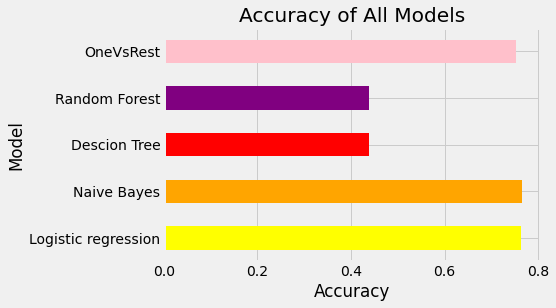

In [69]:
matplotlib.style.use('fivethirtyeight')
df['Accuracy'].plot(kind="barh", color=['yellow', 'orange', 'red', 'purple', 'pink'])
plt.title('Accuracy of All Models')
plt.ylabel('Model')
plt.xlabel('Accuracy')
plt.show()

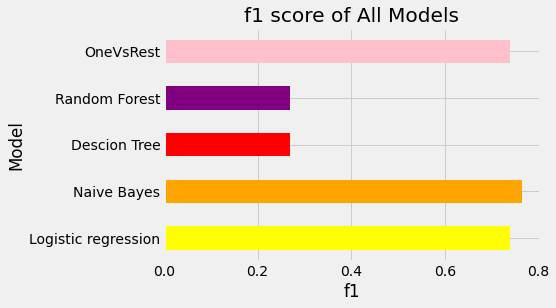

In [70]:
matplotlib.style.use('fivethirtyeight')
df['f1'].plot(kind="barh", color=['yellow', 'orange', 'red', 'purple', 'pink'])
plt.title('f1 score of All Models')
plt.ylabel('Model')
plt.xlabel('f1')
plt.show()

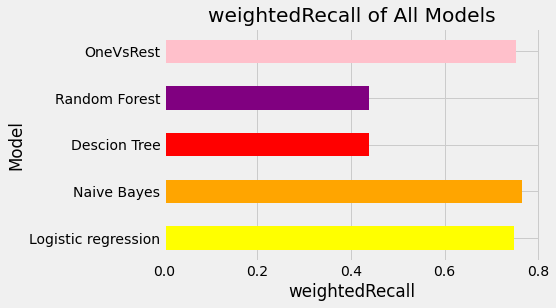

In [71]:
matplotlib.style.use('fivethirtyeight')
df['weightedRecall'].plot(kind="barh", color=['yellow', 'orange', 'red', 'purple', 'pink'])
plt.title('weightedRecall of All Models')
plt.ylabel('Model')
plt.xlabel('weightedRecall')
plt.show()

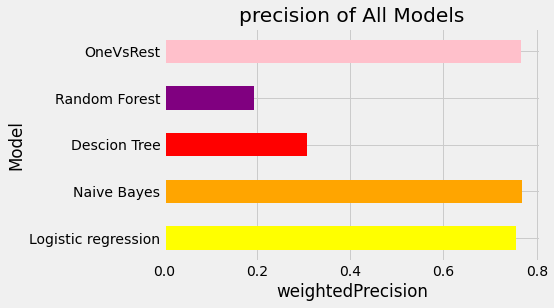

In [72]:
matplotlib.style.use('fivethirtyeight')
df['weightedPrecision'].plot(kind="barh", color=['yellow', 'orange', 'red', 'purple', 'pink'])
plt.title('precision of All Models')
plt.ylabel('Model')
plt.xlabel('weightedPrecision')
plt.show()

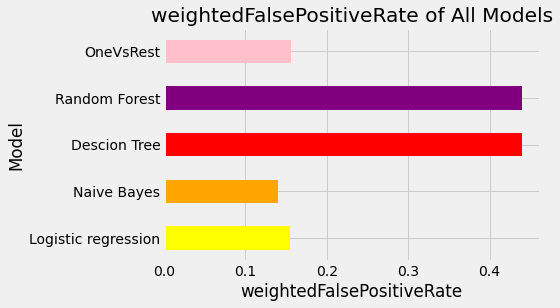

In [73]:
matplotlib.style.use('fivethirtyeight')
df['weightedFalsePositiveRate'].plot(kind="barh", color=['yellow', 'orange', 'red', 'purple', 'pink'])
plt.title('weightedFalsePositiveRate of All Models')
plt.ylabel('Model')
plt.xlabel('weightedFalsePositiveRate')
plt.show()

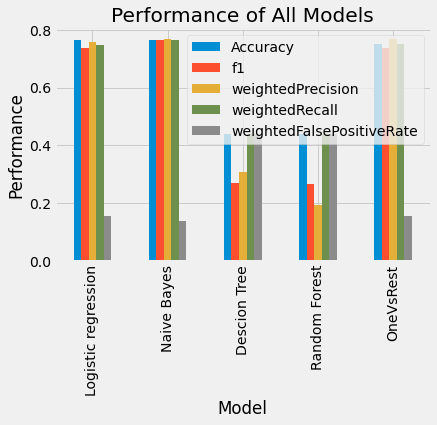

In [74]:
matplotlib.style.use('fivethirtyeight')
df.plot(kind="bar", stacked = False )
plt.title('Performance of All Models')
plt.xlabel('Model')
plt.ylabel('Performance')
plt.show()

In [75]:
df3 = data.toPandas()

In [76]:
positives = df3['category'][df3.category == 1]
negatives = df3['category'][df3.category == -1]
neutrals = df3['category'][df3.category == 0]
print('number of positve categorized text is:  {}'.format(len(positives)))
print('number of negative categorized text is: {}'.format(len(negatives)))
print('number of neutral categorized text is: {}'.format(len(neutrals)))

number of positve categorized text is:  86224
number of negative categorized text is: 42908
number of neutral categorized text is: 66446


array([[<AxesSubplot:title={'center':'category'}>]], dtype=object)

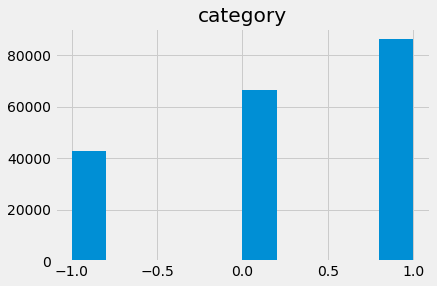

In [77]:
df3.hist('category')